# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [40]:
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

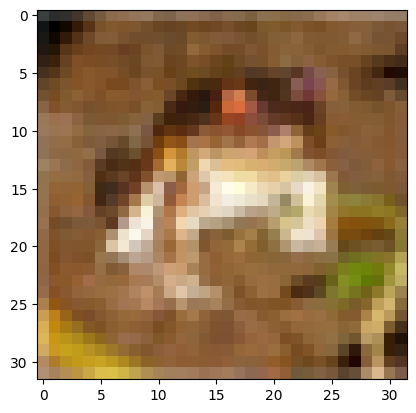

In [41]:
# data loading
cifar_sample = np.load("resources/cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [42]:
def in_range(i, j , filter_size, h, w):
    if i+filter_size-1 < h and  j+filter_size-1 < w: return True
    else: return False

def convolution_sum(image, filter, from_raw, from_col, to_raw, to_col):
    sum = 0
    row = 0
    for i in range(from_raw, to_raw):
        col = 0
        for j in range(from_col, to_col):
            sum += image[i][j] * filter[row][col]
            col += 1
        row += 1
    return sum


def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = int(((img_height- filter_size +2*padding)/stride) +1)
    out_width = int(((img_width - filter_size + 2*padding) / stride) + 1)
    out_channels = n_filters
    
    # your code here
    
    out_image = torch.zeros(out_channels, out_height, out_width)
    
    image = torch.nn.functional.pad(image, (padding, padding, padding, padding), mode='constant', value=0)
    img_channels, img_height, img_width = image.shape
    
    for filter_index in range(n_filters):
        for channel_index in range(img_channels):
            row = 0
            for i in range(0, img_height, stride):
                col = 0
                for j in range(0, img_width, stride):
                    if in_range(i, j, filter_size, img_height, img_width):
                        filter = filters[filter_index][channel_index]
                        
                        out_image[filter_index][row][col] += convolution_sum(image[channel_index], filter, i, j, i+filter_size, j+filter_size)
                        col += 1
                row += 1
                    
        for i in range(out_height):
            for j in range(out_width):
                out_image[filter_index][i][j] += bias[filter_index]
                    
    return out_image

In [43]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [44]:
def get_max(imageLayer, from_raw, from_col, to_raw, to_col):
    Max = 0
    for i in range(from_raw, to_raw):
        for j in range(from_col, to_col):
            Max = max(imageLayer[i][j], Max)
    return Max


def in_range(i, j , kernel_size, h, w):
    if i+kernel_size-1 < h and  j+kernel_size-1 < w: return True
    else: return False

def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = int(((img_height - kernel_size + 2*padding) / stride) + 1)
    out_width = int(((img_width - kernel_size + 2*padding) / stride) + 1)
    out_channels = img_channels

    # your code here

    out_image = torch.zeros(out_channels, out_height, out_width)
    image = torch.nn.functional.pad(image, (padding, padding, padding, padding), mode='constant', value=0)
    img_channels, img_height, img_width = image.shape
    
    for channel_id in range(img_channels):
        row = 0
        for i in range(0, img_height, stride):
            col = 0
            for j in range(0, img_width, stride):
                if (in_range(i, j, kernel_size, img_height, img_width)):
                    out_image[channel_id][row][col] = get_max(image[channel_id], i, j, i+kernel_size, j+kernel_size)
                    col += 1
            row += 1

    return out_image

In [45]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [46]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


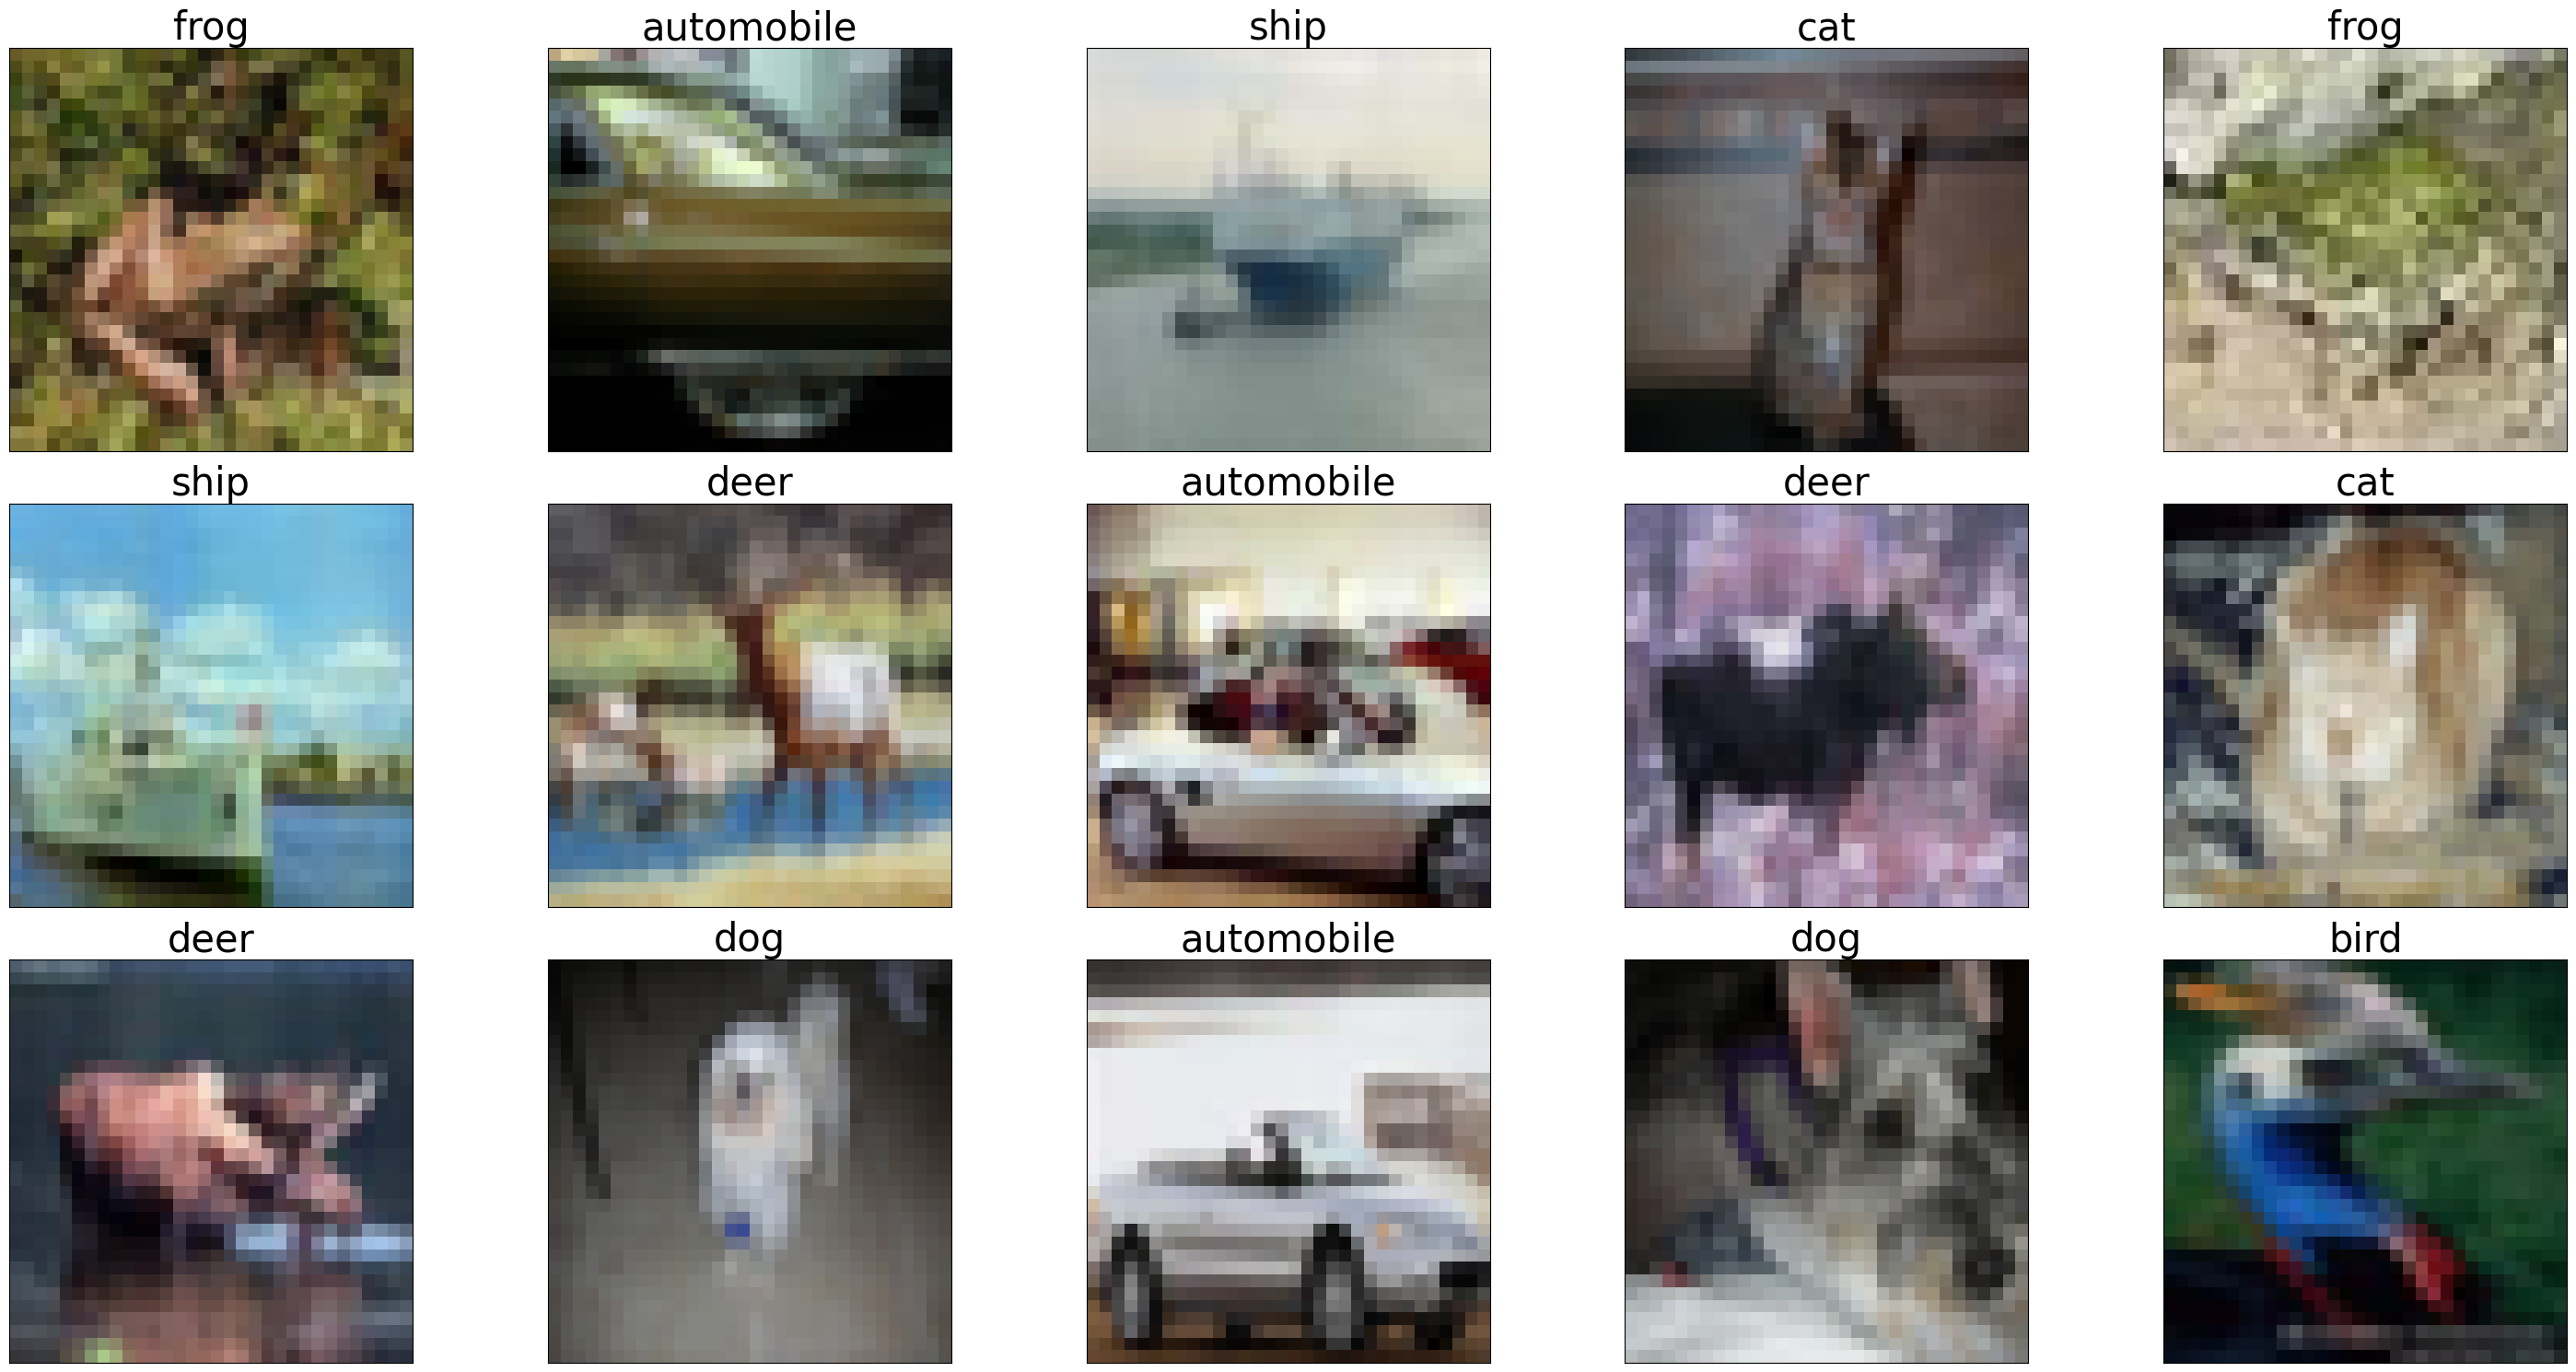

In [47]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [48]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
        self.act = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
    
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.norm1 = torch.nn.BatchNorm2d(32)
        self.drop1 = torch.nn.Dropout(0.2)
    
        self.conv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.norm2 = torch.nn.BatchNorm2d(64)
    
        self.conv3 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.norm3 = torch.nn.BatchNorm2d(128)
    
        self.flat = torch.nn.Flatten()
        self.lin1 = torch.nn.Linear(128*4*4, 1024)
        self.lin2 = torch.nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)  #3 x 32 x 32 => 32 x 32 x 32
        x = self.norm1(x)
        x = self.act(x)
        x = self.pool(x)  #32 x 32 x 32 => 32 x 16 x 16
        x = self.drop1(x)
    
        x = self.conv2(x)  #32 x 16 x 16 => 64 x 16 x 16
        x = self.norm2(x)
        x = self.act(x)
        x = self.pool(x)  #64 x 16 x 16 => 64 x 8 x 8
    
        x = self.conv3(x)  #64 x 8 x 8 => 128 x 8 x 8
        x = self.norm3(x)
        x = self.act(x)
        x = self.pool(x)  #128 x 8 x 8 => 128 x 4 x 4
    
        x = self.flat(x)
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)

        return x
    
    
def train(model, device, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_predictions, total_samples = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        images, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, pred = torch.max(output, 1)
        correct_predictions += (pred == target).sum().item()
        total_samples += target.size(0)
        if (batch_idx + 1) % 100 == 0:
            print(
                f"Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}, Accuracy: {100 * correct_predictions / total_samples:.2f}")
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = 100 * correct_predictions / total_samples
    print(f"Epoch Loss: {epoch_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions, total_samples = 0, 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            images, target = data.to(device), target.to(device)
            
            output = model(images)
            loss = criterion(output, target)
            running_loss += loss.item() * images.size(0)
            
            _, pred = torch.max(output, 1)
            correct_predictions += (pred == target).sum().item()
            total_samples += target.size(0)
            
            if (batch_idx + 1) % 1 == 0:
                print(
                    f"Evaluation Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}, Accuracy: {100 * correct_predictions / total_samples:.2f}")
    eval_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct_predictions / total_samples
    print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return eval_loss, accuracy

In [49]:
from torchvision.transforms.v2 import Compose, Normalize

# tutaj uzupełnij ładowanie danych treningowych i testowych
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


Using device: mps
Batch [100/1563], Loss: 1.9900, Accuracy: 31.16
Batch [200/1563], Loss: 1.5752, Accuracy: 37.39
Batch [300/1563], Loss: 1.2434, Accuracy: 40.80
Batch [400/1563], Loss: 1.5447, Accuracy: 42.99
Batch [500/1563], Loss: 1.7121, Accuracy: 45.01
Batch [600/1563], Loss: 1.2418, Accuracy: 45.96
Batch [700/1563], Loss: 1.2565, Accuracy: 47.64
Batch [800/1563], Loss: 1.1076, Accuracy: 49.04
Batch [900/1563], Loss: 1.4354, Accuracy: 50.17
Batch [1000/1563], Loss: 1.3400, Accuracy: 51.27
Batch [1100/1563], Loss: 1.0721, Accuracy: 52.32
Batch [1200/1563], Loss: 0.9229, Accuracy: 53.22
Batch [1300/1563], Loss: 0.6892, Accuracy: 54.16
Batch [1400/1563], Loss: 1.1946, Accuracy: 54.88
Batch [1500/1563], Loss: 1.1293, Accuracy: 55.46
Epoch Loss: 1.2246, Epoch Accuracy: 55.8100
Evaluation Batch [1/2], Loss: 0.9563, Accuracy: 66.62
Evaluation Batch [2/2], Loss: 0.9651, Accuracy: 66.34
Test Loss: 0.9607, Test Accuracy: 66.34%
Epoch [1/10], Train Loss: 1.2246, Train Accuracy: 55.81%, Test 

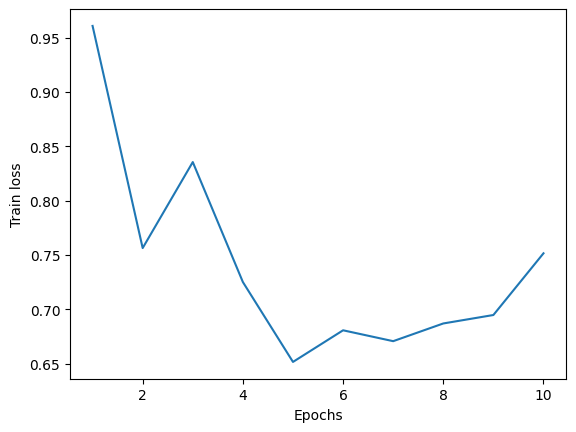

In [50]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
model = CNN().to(device)

#hyperparameters
epochs = 10
lr = 0.001
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


data_loss = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_fun)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fun)
    data_loss.append(test_loss)
    print(
            f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

########################################
plt.plot(range(1,epochs+1), data_loss)
plt.xlabel("Epochs")
plt.ylabel("Train loss")
########################################


#Testing
accuracy = 0
model.eval()
test_loss = 0

with torch.no_grad():
	for (input_imgs, outputs) in test_loader:
		input_imgs = input_imgs.to(device)
		outputs = outputs.to(device)

		results = model(input_imgs)
		loss = loss_fun(results, outputs)
		test_loss += loss.item()

		_, predictions = torch.max(results.data, 1)
		accuracy += (predictions == outputs).sum().item()

	print(f"Accuracy of a test = {100 * accuracy / len(test_dataset)} %")
	print(f"Test loss = {test_loss / len(test_loader)}")

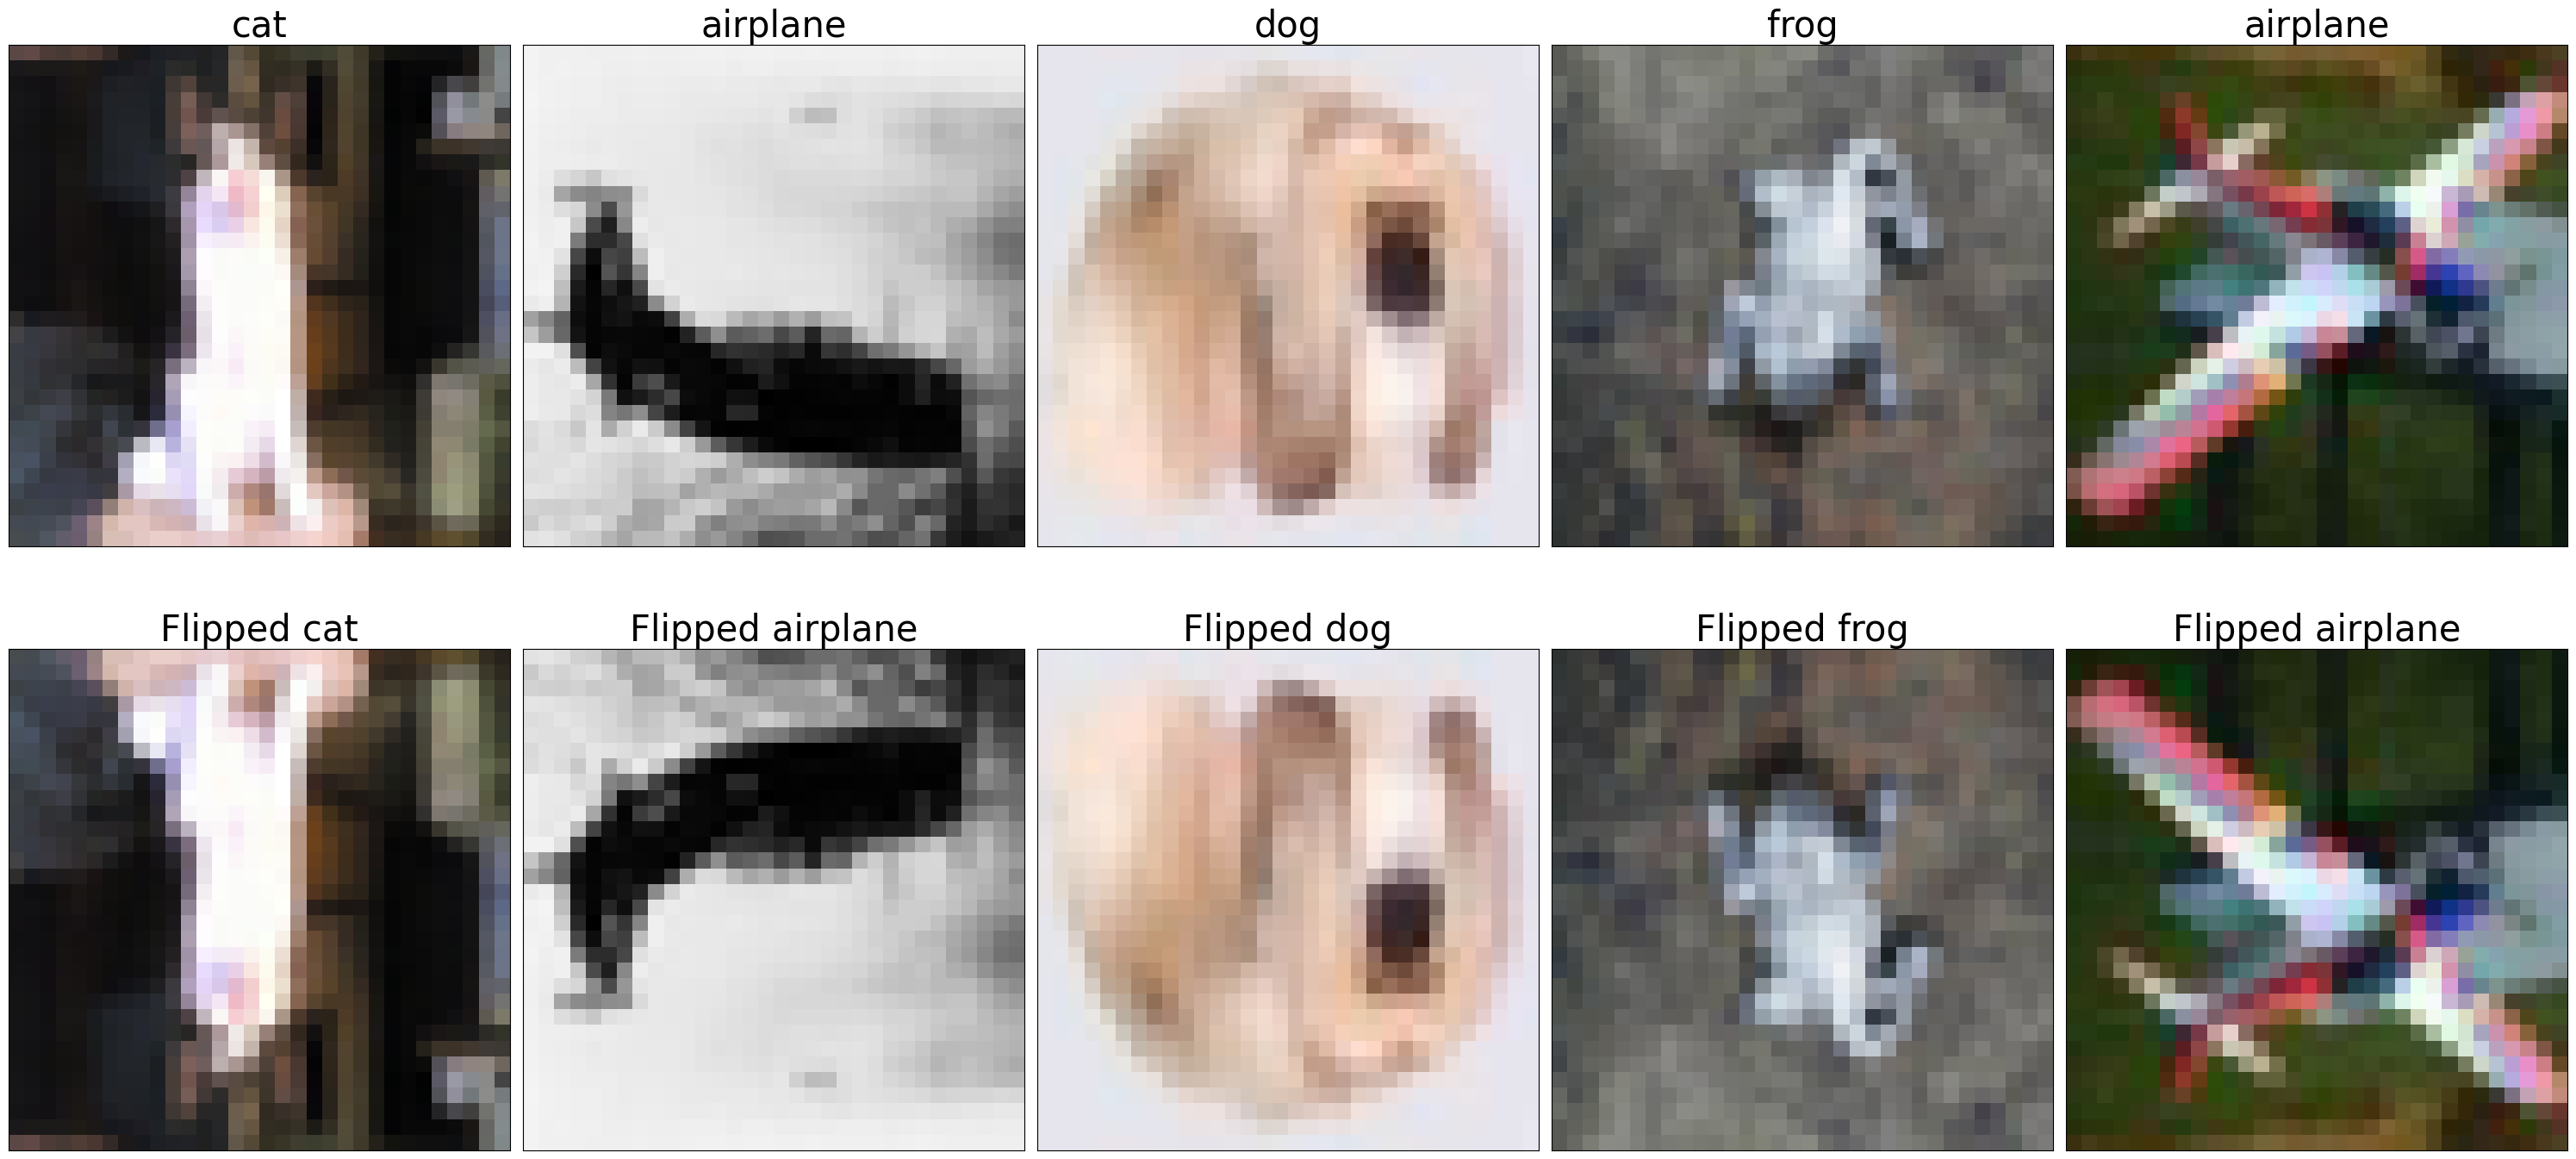

In [51]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

Files already downloaded and verified
Files already downloaded and verified
Using device: mps
Batch [100/1563], Loss: 1.8759, Accuracy: 26.44
Batch [200/1563], Loss: 1.5074, Accuracy: 30.28
Batch [300/1563], Loss: 1.4506, Accuracy: 33.57
Batch [400/1563], Loss: 1.3559, Accuracy: 35.97
Batch [500/1563], Loss: 1.6172, Accuracy: 37.65
Batch [600/1563], Loss: 1.3218, Accuracy: 38.73
Batch [700/1563], Loss: 1.2062, Accuracy: 39.60
Batch [800/1563], Loss: 1.3586, Accuracy: 40.45
Batch [900/1563], Loss: 1.7400, Accuracy: 41.52
Batch [1000/1563], Loss: 1.1497, Accuracy: 42.52
Batch [1100/1563], Loss: 1.2979, Accuracy: 43.42
Batch [1200/1563], Loss: 1.2362, Accuracy: 44.14
Batch [1300/1563], Loss: 1.2720, Accuracy: 44.92
Batch [1400/1563], Loss: 1.3695, Accuracy: 45.65
Batch [1500/1563], Loss: 0.8308, Accuracy: 46.32
Epoch Loss: 1.4522, Epoch Accuracy: 46.7540
Evaluation Batch [1/2], Loss: 1.1787, Accuracy: 57.20
Evaluation Batch [2/2], Loss: 1.1855, Accuracy: 56.83
Test Loss: 1.1821, Test Accu

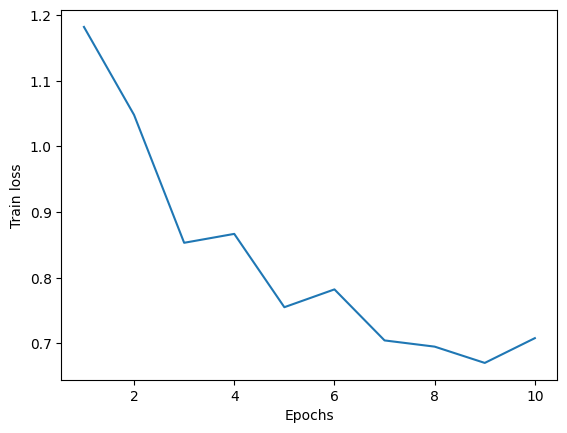

In [52]:
from torchvision import transforms

# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
transformRandom =Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transformRandom)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transformRandom)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=10)


device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
model = CNN().to(device)

#hyperparameters
epochs = 10
lr = 0.001
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


data_loss = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_fun)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fun)
    data_loss.append(test_loss)
    print(
            f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

########################################
plt.plot(range(1,epochs+1), data_loss)
plt.xlabel("Epochs")
plt.ylabel("Train loss")
########################################


#Testing
accuracy = 0
model.eval()
test_loss = 0

with torch.no_grad():
	for (input_imgs, outputs) in test_loader:
		input_imgs = input_imgs.to(device)
		outputs = outputs.to(device)

		results = model(input_imgs)
		loss = loss_fun(results, outputs)
		test_loss += loss.item()

		_, predictions = torch.max(results.data, 1)
		accuracy += (predictions == outputs).sum().item()

	print(f"Accuracy of a test = {100 * accuracy / len(test_dataset)} %")
	print(f"Test loss = {test_loss / len(test_loader)}")